# **NAVEGACIÓN AUTÓNOMA**

# **Actividad 3.1 DETECCIÓN DE PEATONES CON SVM Y HOG**

#### **Equipo 13:**

- Lineth Del Carmen Guerra Camarena    A01795639
- Monserrat Moreno Martínez            A01339189
- Erick Rosales Alvarez                A00954533


#### En esta actividad calcularemos el HOG y SVM para la detección de peatones y no peatones. El HOG verifica los píxeles circundantes de cada píxel. El objetivo es comprobar qué tan oscuro es el píxel actual en comparación con los píxeles circundantes. El algoritmo dibuja flechas que indican la dirección del oscurecimiento de la imagen. Repite el proceso para cada píxel. Finalmente, cada píxel se reemplaza por una flecha llamada gradiente . Estos gradientes muestran el flujo de luz de claro a oscuro. Mediante estos gradientes, los algoritmos realizan análisis adicionales.

#### SVM ofrece una exactitud muy alta en comparación con otros clasificadores, como la regresión logística y los árboles de decisión. Son conocidas por su truco del kernel para manejar espacios de entrada no lineales. Se utilizan en diversas aplicaciones, como la detección de caras, la detección de intrusos, la clasificación de correos electrónicos, artículos de noticias y páginas web, la clasificación de genes y el reconocimiento de escritura.

## **Importación de líbrerias y dataset**

In [125]:
#bibliotecas necesarias para el experimento
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import seaborn as sns

from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2yuv
from skimage.io import imread
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [126]:
#trabajo con Google colaboratory, importo los datos desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import os
DIR = "/content/drive/MyDrive/NAVEGACION"
os.chdir(DIR)

In [128]:
peatones = glob.glob("peatones/*.jpg")
no_peatones = glob.glob("nopeatones/*.*")

In [129]:
len(peatones)

100

In [130]:
len(no_peatones)

235

## **Extraemos el HOG con el color YUV antes del cálculo**

In [131]:
def extract_hog_yuv(image, visualize=False, size=(64, 64)):
    """
    Extrae características HOG de una imagen en espacio de color YUV.

    Args:
        image (ndarray): Imagen RGB de entrada.
        visualize (bool): Si es True, muestra visualización de HOG por canal.
        size (tuple): Dimensión para redimensionar la imagen (por defecto 64x64).

    Returns:
        ndarray: Vector de características HOG concatenado de los 3 canales (Y, U, V).
    """
    # 1. Redimensionar imagen a tamaño fijo
    image_resized = resize(image, size, anti_aliasing=True)

    # 2. Convertir de RGB a YUV
    yuv = rgb2yuv(image_resized)

    # 3. Asegurar valores en el rango [0, 1] para evitar errores con sqrt
    yuv = np.clip(yuv, 0, 1)

    hog_features = []
    hog_images = []

    # 4. Calcular HOG para cada canal (Y, U, V)
    for channel_index, channel_name in enumerate(['Y', 'U', 'V']):
        features, hog_img = hog(
            yuv[:, :, channel_index],
            orientations=11,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            transform_sqrt=True,
            visualize=True,
            feature_vector=True
        )
        hog_features.append(features)
        hog_images.append(hog_img)

    # 5. Visualización
    if visualize:
        fig, axs = plt.subplots(1, 4, figsize=(14, 4))
        axs[0].imshow(image_resized)
        axs[0].set_title("Imagen original")

        for i, label in enumerate(['Y', 'U', 'V']):
            axs[i + 1].imshow(
                exposure.rescale_intensity(hog_images[i], in_range=(0, 10)),
                cmap='gray'
            )
            axs[i + 1].set_title(f'HOG {label}')

        plt.suptitle("Visualización HOG por canal (YUV)", fontsize=14)
        plt.tight_layout()
        plt.show()

    # 6. Concatenar los vectores HOG de los 3 canales
    return np.concatenate(hog_features)

Visualizando imagen PEATÓN:


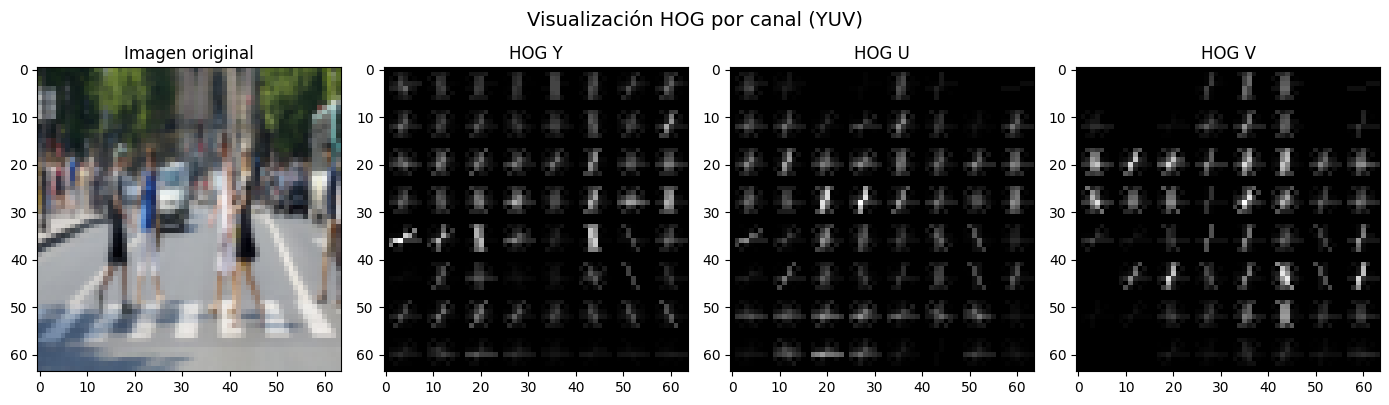

Visualizando imagen NO PEATÓN:


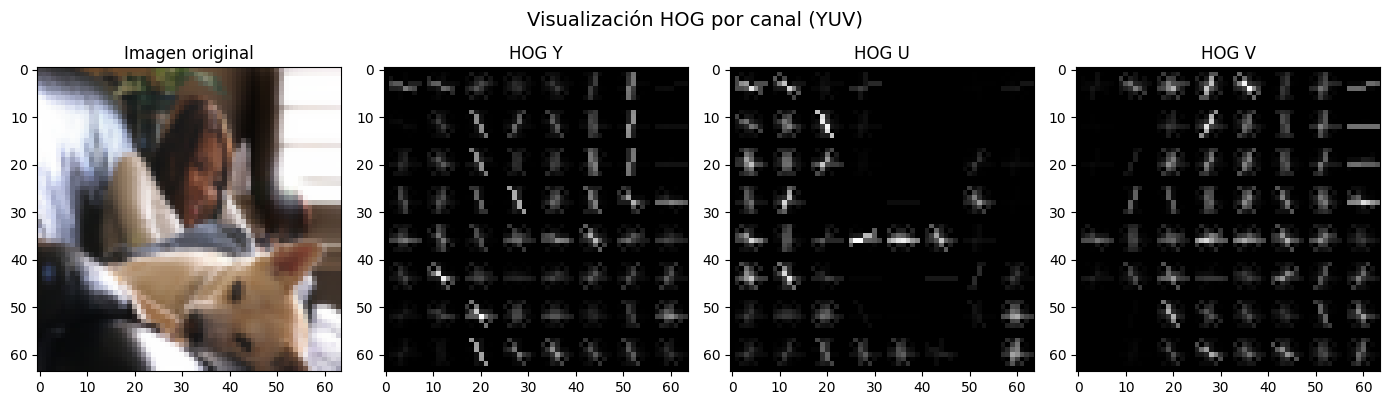

In [132]:
def load_images_and_compare():
    # Selecciona una imagen positiva y negativa para comparar visualmente
    pos_img = imread(peatones[0])
    neg_img = imread(no_peatones[0])

    print("Visualizando imagen PEATÓN:")
    extract_hog_yuv(pos_img, visualize=True)

    print("Visualizando imagen NO PEATÓN:")
    extract_hog_yuv(neg_img, visualize=True)

load_images_and_compare()

## **Mostramos una imagen con peatones**

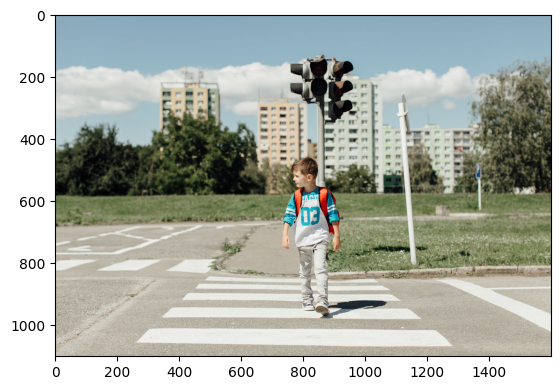

In [133]:
img_color = cv2.imread(peatones[59])
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)

## **Calculamos el HOG de la imagen con peatones**

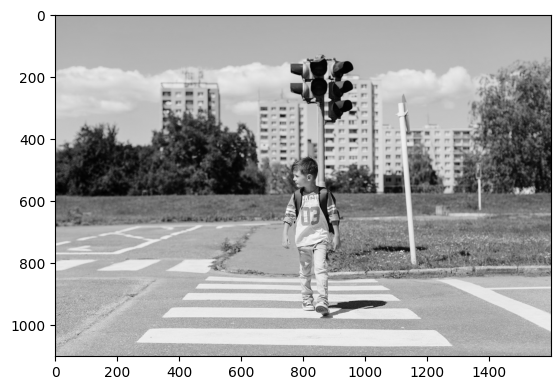

In [134]:
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

In [135]:
features, hog_img = hog(img_gray,
                        orientations=11,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        transform_sqrt=False,
                        visualize=True,
                        feature_vector=True)

#funciona para mejorar la visualización del HOG
hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

In [136]:
features.shape

(1190816,)

In [137]:
hog_img.shape

(1100, 1600)

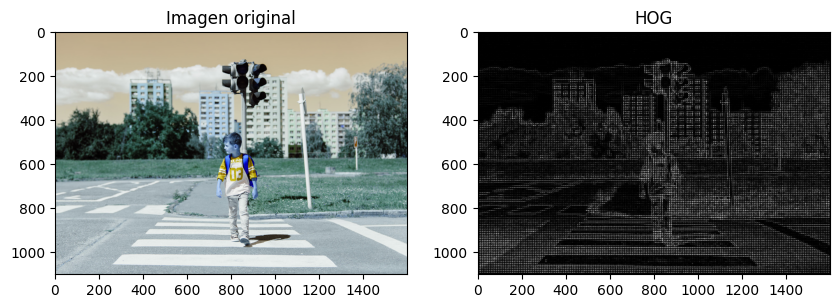

In [138]:
#mostrar la imagen original y el HOG
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")

plt.subplot(1, 2, 2)
plt.imshow(hog_img_rescaled, cmap='gray')
plt.title("HOG")

plt.show()

## **Features del HOG para ambos tipos de datos**

In [139]:
peatones_hog_acumm = []
size_hog = (128,64)

for i in peatones:
  try:
        # Leer imagen con matplotlib (RGB float)
        img_color = mpimg.imread(i)

        # Convertir a uint8 si está en float (0-1)
        if img_color.dtype == 'float32' or img_color.dtype == 'float64':
            img_color = (img_color * 255).astype('uint8')

        # Convertir RGB a gris (cv2 espera BGR, así que cambiamos a BGR para cvtColor)
        img_bgr = cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        #redimenzionar
        img_gray_resized = cv2.resize(img_gray, size_hog)

        peatones_hog_feature, peatones_hog_img =hog(img_gray_resized,
                                                    orientations=11,
                                                    pixels_per_cell=(16, 16),
                                                    cells_per_block=(2, 2),
                                                    transform_sqrt=False,
                                                    visualize=True,
                                                    feature_vector=True)

        peatones_hog_acumm.append(peatones_hog_feature)

  except Exception as e:
        print(f"Error con la imagen {i}: {e}")

print(f"Total de features extraídas: {len(peatones_hog_acumm)}")


Total de features extraídas: 100


In [140]:
# Apila verticalmente (en filas) todos los vectores HOG almacenados en la lista peatones_hog_acumm
# Cada elemento de peatones_hog_acumm es un vector de características HOG de una imagen de peatón
X_peatones = np.vstack(peatones_hog_acumm).astype(np.float64)

# Crea un vector de etiquetas (target) con valor 1 para cada ejemplo de peatón,
# del mismo tamaño que el número de muestras en X_peatones
y_peatones = np.ones(len(X_peatones))

In [141]:
X_peatones.shape

(100, 924)

In [142]:
y_peatones.shape

(100,)

In [143]:
no_peatones_hog_acumm = []
size_hog = (128,64)

for i in no_peatones:
  try:
        # Leer imagen con matplotlib (RGB float)
        img_color = mpimg.imread(i)

        # Convertir a uint8 si está en float (0-1)
        if img_color.dtype == 'float32' or img_color.dtype == 'float64':
            img_color = (img_color * 255).astype('uint8')

        # Convertir RGB a gris (cv2 espera BGR, así que cambiamos a BGR para cvtColor)
        img_bgr = cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        #redimenzionar
        img_gray_resized = cv2.resize(img_gray, size_hog)

        no_peatones_hog_feature, no_peatones_hog_img =hog(img_gray_resized,
                                                    orientations=11,
                                                    pixels_per_cell=(16, 16),
                                                    cells_per_block=(2, 2),
                                                    transform_sqrt=False,
                                                    visualize=True,
                                                    feature_vector=True)

        no_peatones_hog_acumm.append(no_peatones_hog_feature)

  except Exception as e:
        print(f"Error con la imagen {i}: {e}")

print(f"Total de features extraídas: {len(no_peatones_hog_acumm)}")

Total de features extraídas: 235


In [144]:
X_nopeatones = np.vstack(no_peatones_hog_acumm).astype(np.float64)
y_nopeatones = np.zeros(len(X_nopeatones))

In [145]:
X_nopeatones.shape

(235, 924)

In [146]:
y_nopeatones.shape

(235,)

## **Combinamos ambos tipos de datos para alimentar el SVM**

In [147]:
X=np.vstack((X_peatones,X_nopeatones))
y=np.hstack((y_peatones,y_nopeatones))

In [148]:
X.shape

(335, 924)

In [149]:
y.shape

(335,)

## **Generamos los datos de entrenamiento y de prueba**

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
X_train.shape

(268, 924)

In [152]:
X_test.shape

(67, 924)

## **Clasificador SVC**

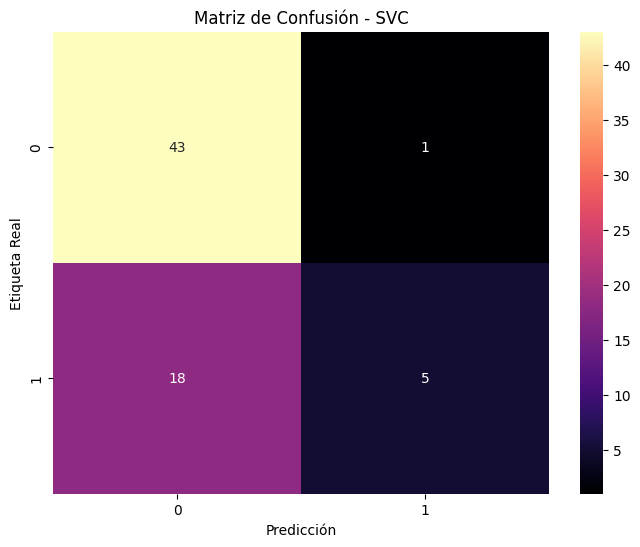

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.70      0.98      0.82        44
         1.0       0.83      0.22      0.34        23

    accuracy                           0.72        67
   macro avg       0.77      0.60      0.58        67
weighted avg       0.75      0.72      0.66        67

Accuracy del modelo SVC: 0.7164


In [153]:
# Entrenar el modelo
svc_model = SVC()
svc_model.fit(X_train, y_train)

# Predecir en test
y_pred = svc_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar matriz de confusión con seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma")
plt.title("Matriz de Confusión - SVC")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


# Reporte de clasificación
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:\n", report)

# Calcular y mostrar accuracy para saber el mejor resultado
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo SVC: {accuracy:.4f}")

## **GridSearch para SVC, KNN y Logistic Regression para optimizar hiperparámetros**

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--- Resultados SVC ---
Mejores parámetros: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy: 0.8358
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89        44
         1.0       0.93      0.57      0.70        23

    accuracy                           0.84        67
   macro avg       0.87      0.77      0.79        67
weighted avg       0.85      0.84      0.82        67



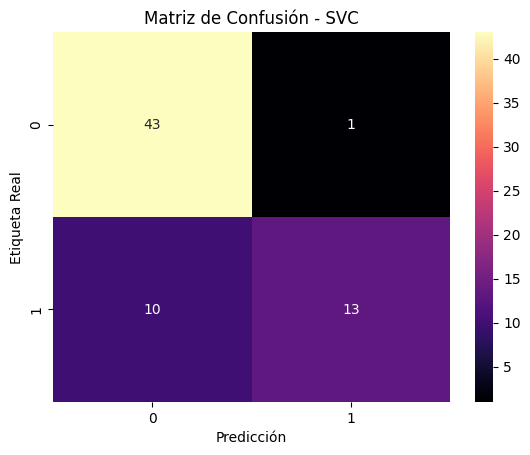

--- Resultados Random Forest ---
Accuracy: 0.7015
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.69      1.00      0.81        44
         1.0       1.00      0.13      0.23        23

    accuracy                           0.70        67
   macro avg       0.84      0.57      0.52        67
weighted avg       0.79      0.70      0.61        67



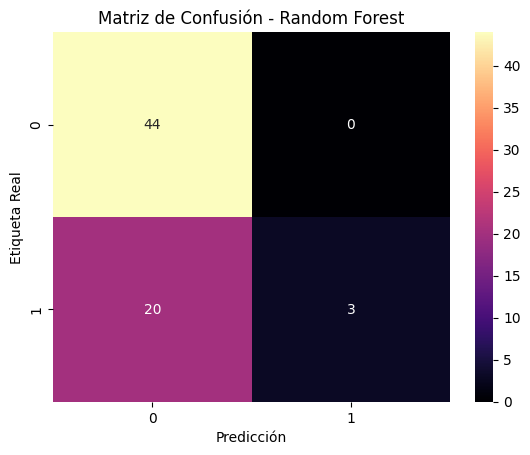

--- Resultados K-Nearest Neighbors ---
Mejores parámetros: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Accuracy: 0.6866
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.75        44
         1.0       0.54      0.65      0.59        23

    accuracy                           0.69        67
   macro avg       0.67      0.68      0.67        67
weighted avg       0.71      0.69      0.69        67



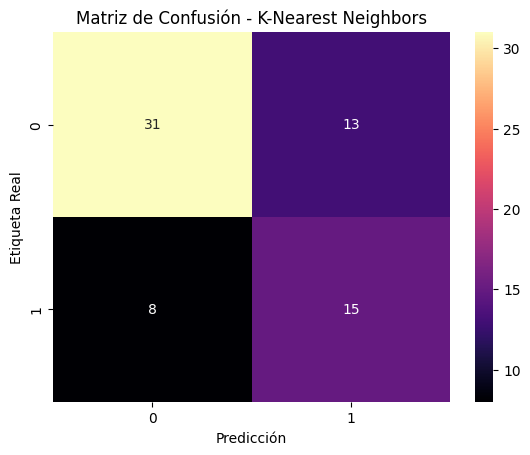

--- Resultados Gradient Boosting ---
Accuracy: 0.7313
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82        44
         1.0       0.78      0.30      0.44        23

    accuracy                           0.73        67
   macro avg       0.75      0.63      0.63        67
weighted avg       0.74      0.73      0.69        67



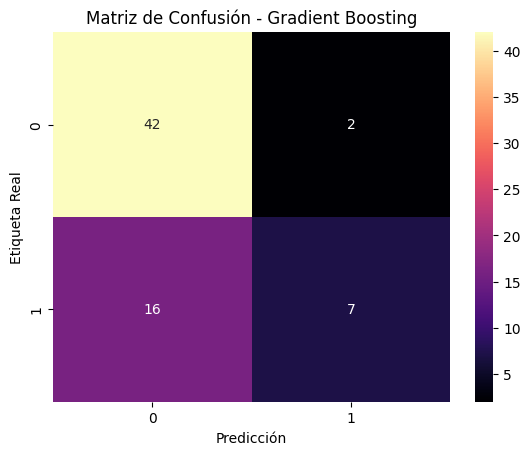

--- Resultados Logistic Regression ---
Mejores parámetros: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Accuracy: 0.7761
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83        44
         1.0       0.68      0.65      0.67        23

    accuracy                           0.78        67
   macro avg       0.75      0.75      0.75        67
weighted avg       0.77      0.78      0.77        67



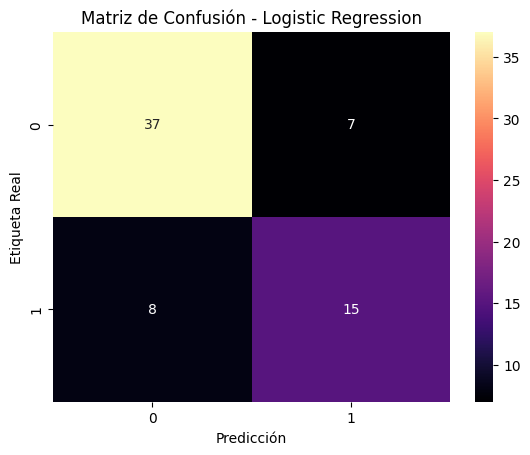


 Mejor modelo: SVC con accuracy = 0.8358


In [154]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="magma")
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. SVC con GridSearchCV
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced'))
])
param_grid_svc = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01],
    'svc__kernel': ['rbf', 'linear']
}
grid_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=cv, refit=True, verbose=2, n_jobs=-1)
grid_svc.fit(X_train, y_train)
svc_predictions = grid_svc.predict(X_test)

# 2. Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

# 3. K-Nearest Neighbors con GridSearchCV
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_grid_knn = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=cv, refit=True, verbose=2, n_jobs=-1)
grid_knn.fit(X_train, y_train)
knn_predictions = grid_knn.predict(X_test)

# 4. Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_predictions = gb.predict(X_test)

# 5. Logistic Regression con GridSearchCV
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000))
])
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv, refit=True, verbose=2, n_jobs=-1)
grid_lr.fit(X_train, y_train)
lr_predictions = grid_lr.predict(X_test)

# Mostrar resultados y almacenar accuracy para comparar
models = {
    "SVC": (grid_svc, svc_predictions),
    "Random Forest": (rf, rf_predictions),
    "K-Nearest Neighbors": (grid_knn, knn_predictions),
    "Gradient Boosting": (gb, gb_predictions),
    "Logistic Regression": (grid_lr, lr_predictions)
}

best_model_name = None
best_accuracy = 0

for name, (model, preds) in models.items():
    print(f"--- Resultados {name} ---")
    if isinstance(model, GridSearchCV):
        print("Mejores parámetros:", model.best_params_)
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: {acc:.4f}")
    print("Reporte de clasificación:")
    print(classification_report(y_test, preds))
    plot_conf_matrix(y_test, preds, f"Matriz de Confusión - {name}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name

print(f"\n Mejor modelo: {best_model_name} con accuracy = {best_accuracy:.4f}")
